# packages

In [20]:
import time
import investpy
# https://investpy.readthedocs.io/_info/introduction.html
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pyfolio as pf #https://quantopian.github.io/pyfolio/ - need to install from git because of dependencies errors
from alpha_vantage.timeseries import TimeSeries
import yfinance as yf #https://pypi.org/project/yfinance/#description
import edhec_risk_kit_129 as erk
import requests
from io import StringIO
from pprint import pprint
import plotly.express as px
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings("ignore")

# finax etfs

In [21]:
df_finax = pickle.load(open('data/df_finax.pickle', 'rb'))

In [22]:
df_finax.head()

Adj Close                                                          \
             DBZB.DE FRCK.DE IS3N.DE SPY4.DE SXR8.DE XBLC.MI XHYA.DE XSX6.MI   
Date                                                                           
2008-03-14       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2008-03-17       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2008-03-18       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2008-03-19       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2008-03-20       NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

                               ...  Volume                                  \
              XXSC.MI ZPRR.DE  ... DBZB.DE FRCK.DE IS3N.DE SPY4.DE SXR8.DE   
Date                           ...                                           
2008-03-14  17.530001     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2008-03-17  16.770000     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2008-03-18  17.080000     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2008-03-19  16.930000     NaN  ...     NaN     NaN     NaN     NaN     NaN   
2008-03-20  16.910000     NaN  ...     NaN     NaN     NaN     NaN     NaN   

                                                    
           XBLC.MI XHYA.DE XSX6.MI XXSC.MI ZPRR.DE  
Date                                                
2008-03-14     NaN     NaN     NaN     0.0     NaN  
2008-03-17     NaN     NaN     NaN     0.0     NaN  
2008-03-18     NaN     NaN     NaN     0.0     NaN  
2008-03-19     NaN     NaN     NaN     0.0     NaN  
2008-03-20     NaN     NaN     NaN     0.0     NaN  

[5 rows x 60 columns]

In [23]:
df_finax = df_finax['Adj Close']

## describe

In [24]:
df_finax.shape

(3317, 10)

In [25]:
df_finax.describe()

DBZB.DE      FRCK.DE      IS3N.DE      SPY4.DE      SXR8.DE  \
count  3148.000000  1215.000000  1716.000000  2314.000000  2751.000000   
mean    211.926352    12.199707    22.894852    38.301536   171.510038   
std      20.659113     0.536425     3.167687    10.902251    70.831971   
min     168.669998     9.811000    15.690000    19.290001    67.669998   
25%     195.310005    11.815750    20.309999    27.787500    99.564999   
50%     217.550003    12.192500    23.180000    39.174999   172.179993   
75%     226.382504    12.641500    24.999250    46.808751   225.104996   
max     249.710007    13.267000    33.192001    66.290001   338.059998   

           XBLC.MI      XHYA.DE      XSX6.MI      XXSC.MI      ZPRR.DE  
count  1896.000000  1019.000000  2977.000000  3304.000000  1601.000000  
mean    147.478838    19.435082    63.211327    29.530379    33.974521  
std      11.627061     0.699483    16.892121    11.763471     5.706116  
min     119.650002    15.626000    22.459999     8.560000    21.950001  
25%     142.122501    19.084999    46.524700    18.567500    29.420000  
50%     150.770004    19.284000    65.750000    29.355000    34.340000  
75%     154.434994    19.871500    78.139999    40.999999    37.485001  
max     164.250000    20.926001    95.459999    55.880001    54.700001

## % nans

In [26]:
df_finax.isna().sum(axis = 'rows')/df_finax.shape[0]

DBZB.DE    0.050950
FRCK.DE    0.633705
IS3N.DE    0.482665
SPY4.DE    0.302382
SXR8.DE    0.170636
XBLC.MI    0.428399
XHYA.DE    0.692795
XSX6.MI    0.102502
XXSC.MI    0.003919
ZPRR.DE    0.517335
dtype: float64

## first valid date

In [27]:
df_finax.apply(lambda x: x.first_valid_index())

DBZB.DE   2008-10-20
FRCK.DE   2016-05-10
IS3N.DE   2014-06-11
SPY4.DE   2012-01-30
SXR8.DE   2010-05-19
XBLC.MI   2010-06-22
XHYA.DE   2017-03-15
XSX6.MI   2009-02-16
XXSC.MI   2008-03-14
ZPRR.DE   2014-11-10
dtype: datetime64[ns]

## timeseries plot

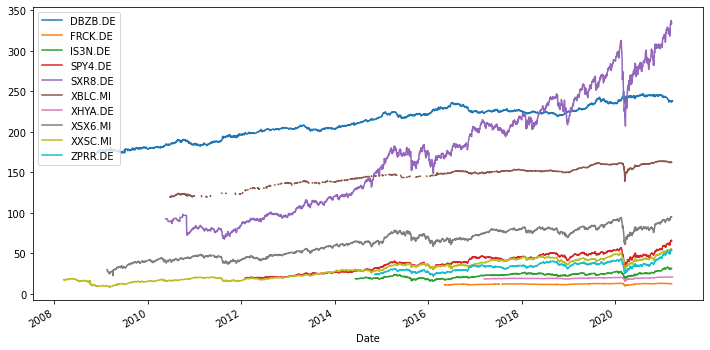

In [28]:
df_finax.plot(figsize = (12,6))

## correlations

In [29]:
df_finax_corr = df_finax.corr()

cm = sns.color_palette("coolwarm", as_cmap=True) # https://seaborn.pydata.org/tutorial/color_palettes.html
s = df_finax_corr.style.background_gradient(cmap=cm, axis = None)
s

# pyfolio stats

## stats definitions

- **annual return** - annualized returns
- **cumulative returns** - cumprod of returns
- **annual volatility** - annualized volatility
- **sharpe ratio** - (annualized returns - risk free rate)/annualized volatility
- **calmar ratio** - It is a function of the expected annual rate of return and the maximum drawdown over the previous three years.
    (annualized returns - risk free)/max drawdown
- **stability** - Determines R-squared of a linear fit to the cumulative log returns. Computes an ordinary least squares linear fit, and returns R-squared. Lower is better
- **max drawdown**  - A maximum drawdown (MDD) is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. Maximum drawdown is an indicator of downside risk over a specified time period. 
- **omega ratio** - sharpe ratio considers only 2 statistical moments (mean, and variance), omega ratio considers all 4 (mean, variance, skewness, kurtosis). Omega is the ratio of upside returns relative to downside returns. The higher the Omega value, the greater the probability that a given return will be achieved or exceeded. A particular feature of the Omega Ratio is that it uses the entire probabilitydistribution of the portfolio return to compute its performance and, therefore, does not suffer from the drawbacksof the mean-variance framework (sharpe ratio).
- **sortino ratio** - The Sortino ratio differs from the Sharpe ratio in that it only considers the standard deviation of the downside risk, rather than that of the entire (upside + downside) risk. (annualized return - risk free rate)/(annualized volatitly of the downside)
- **skewness** - (-0.5, 0.5) - low, (-1, -0.5; 0.5,1) - moderate, (< -1; > 1) - high. Negative skewness - left long tail, Positive - right long tail
- **kurtosis** - high kurtosis - more thinner with long tails. Higher kurtosis corresponds to greater extremity of deviations (or outliers), and not the configuration of data near the mean. A large kurtosis is associated with a high level of risk for an investment because it indicates that there are high probabilities of extremely large and extremely small returns.
- **tail ratio**  - Ratio between the 95th and (absolute) 5th percentile of the daily returns distribution.I n the context of finance, a tail ratio of 0.25, for example, means that losses are four times as bad as profits. Higher is better

## DBZB

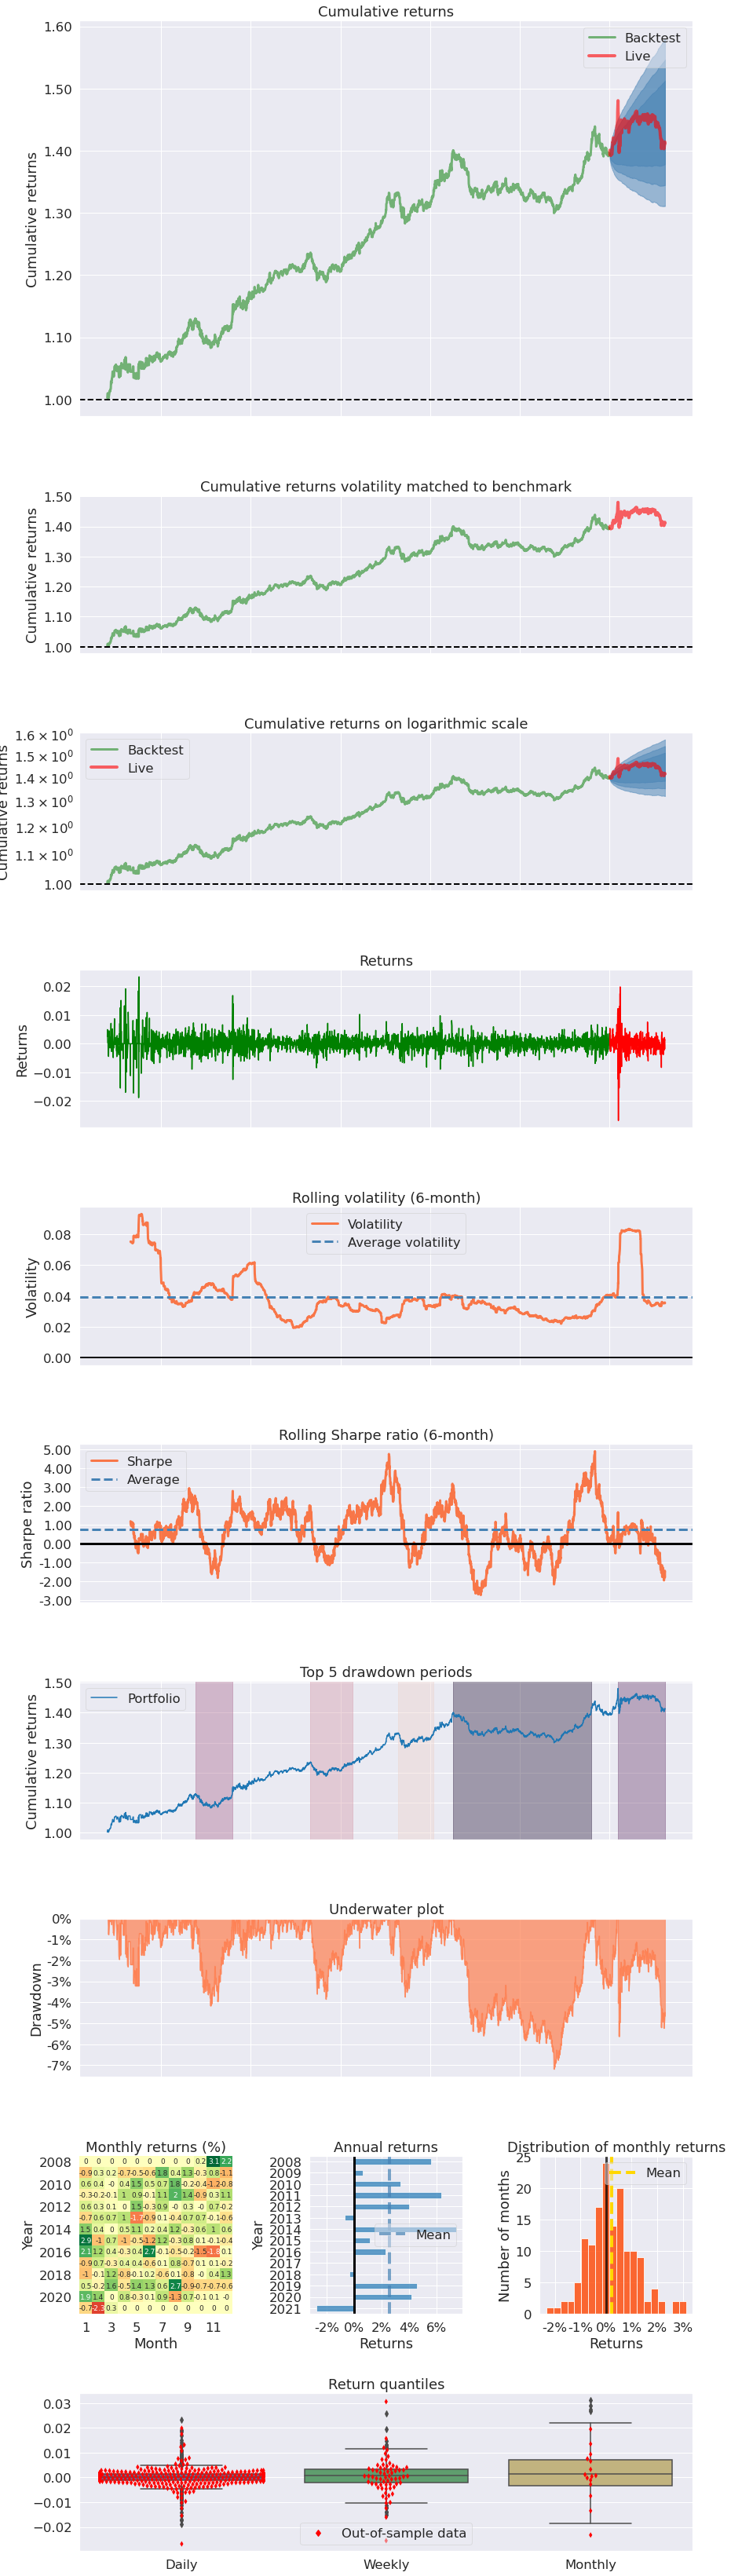

In [30]:
df_finax = df_finax.tz_localize('UTC')
pf.create_returns_tear_sheet(returns = df_finax['DBZB.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')
# https://nbviewer.jupyter.org/format/slides/github/quantopian/pyfolio/blob/master/pyfolio/examples/pyfolio_talk_slides.ipynb#/15
# functions can be calles separately from modules lke:
# pf.timeseries.perf_stats(returns = df_finax['DBZB.DE'].dropna().pct_change().dropna())
# https://github.com/quantopian/pyfolio/blob/master/pyfolio/timeseries.py
# some docu http://quantopian.github.io/empyrical/appendix.html#
# omega ratio https://cs.uwaterloo.ca/~yuying/Courses/CS870_2012/Omega_paper_Short_Cm.pdf

In [31]:
erk.var_gaussian(pd.DataFrame(df_finax['DBZB.DE']).dropna().pct_change().dropna()) # not OK

DBZB.DE    0.004301
dtype: float64

In [32]:
erk.cvar_historic(pd.DataFrame(df_finax['DBZB.DE']).dropna().pct_change().dropna())

DBZB.DE    0.005934
dtype: float64

## FRCK

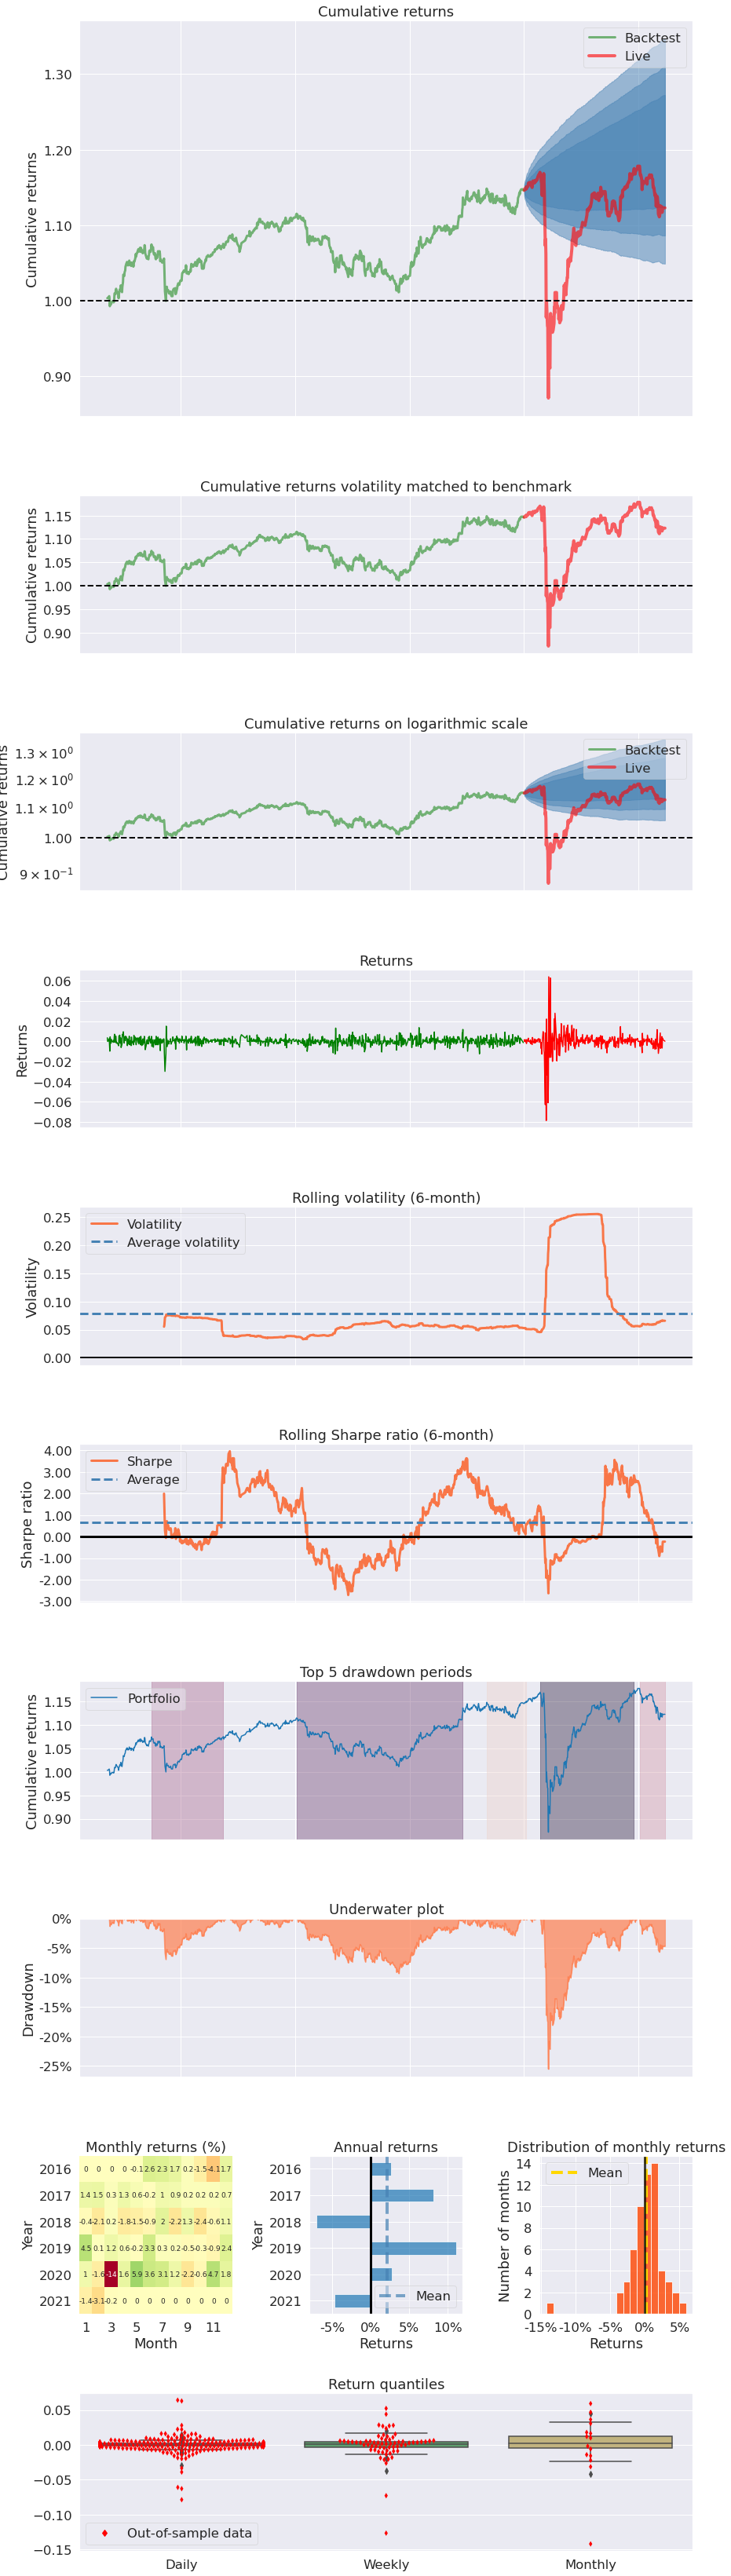

In [33]:
pf.create_returns_tear_sheet(returns = df_finax['FRCK.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## XXSC

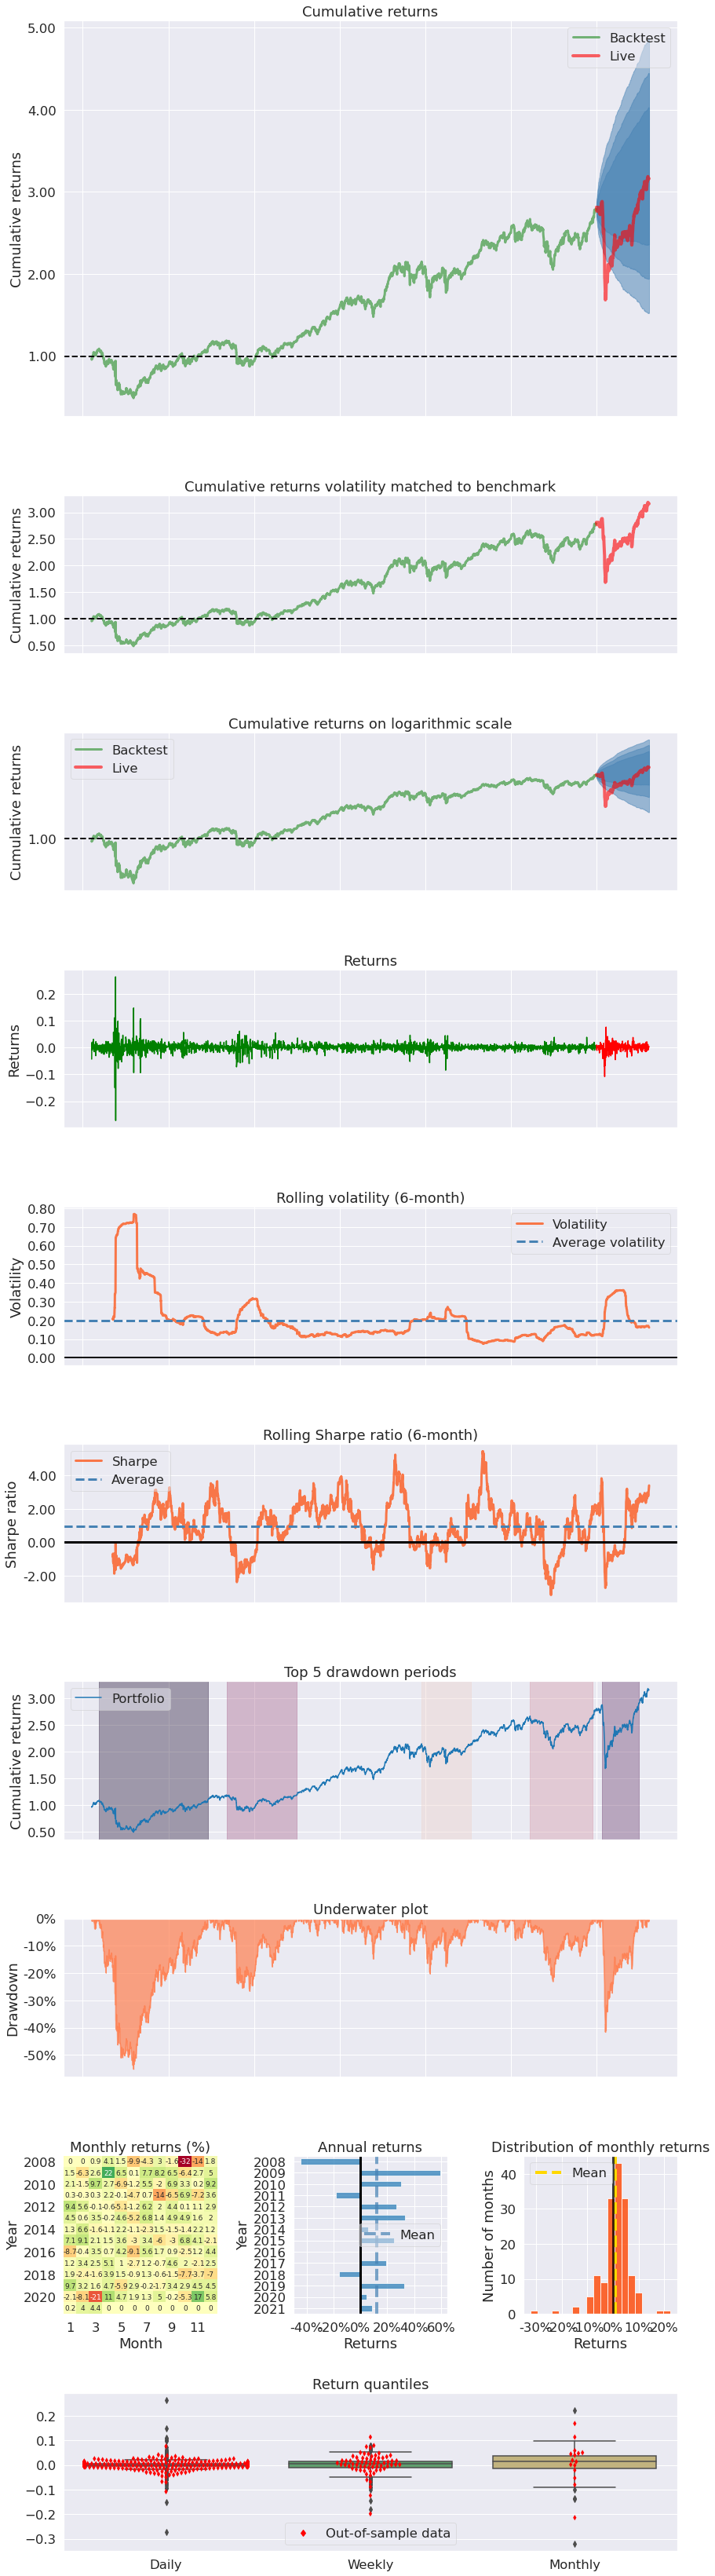

In [34]:
pf.create_returns_tear_sheet(returns = df_finax['XXSC.MI'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## XSX6

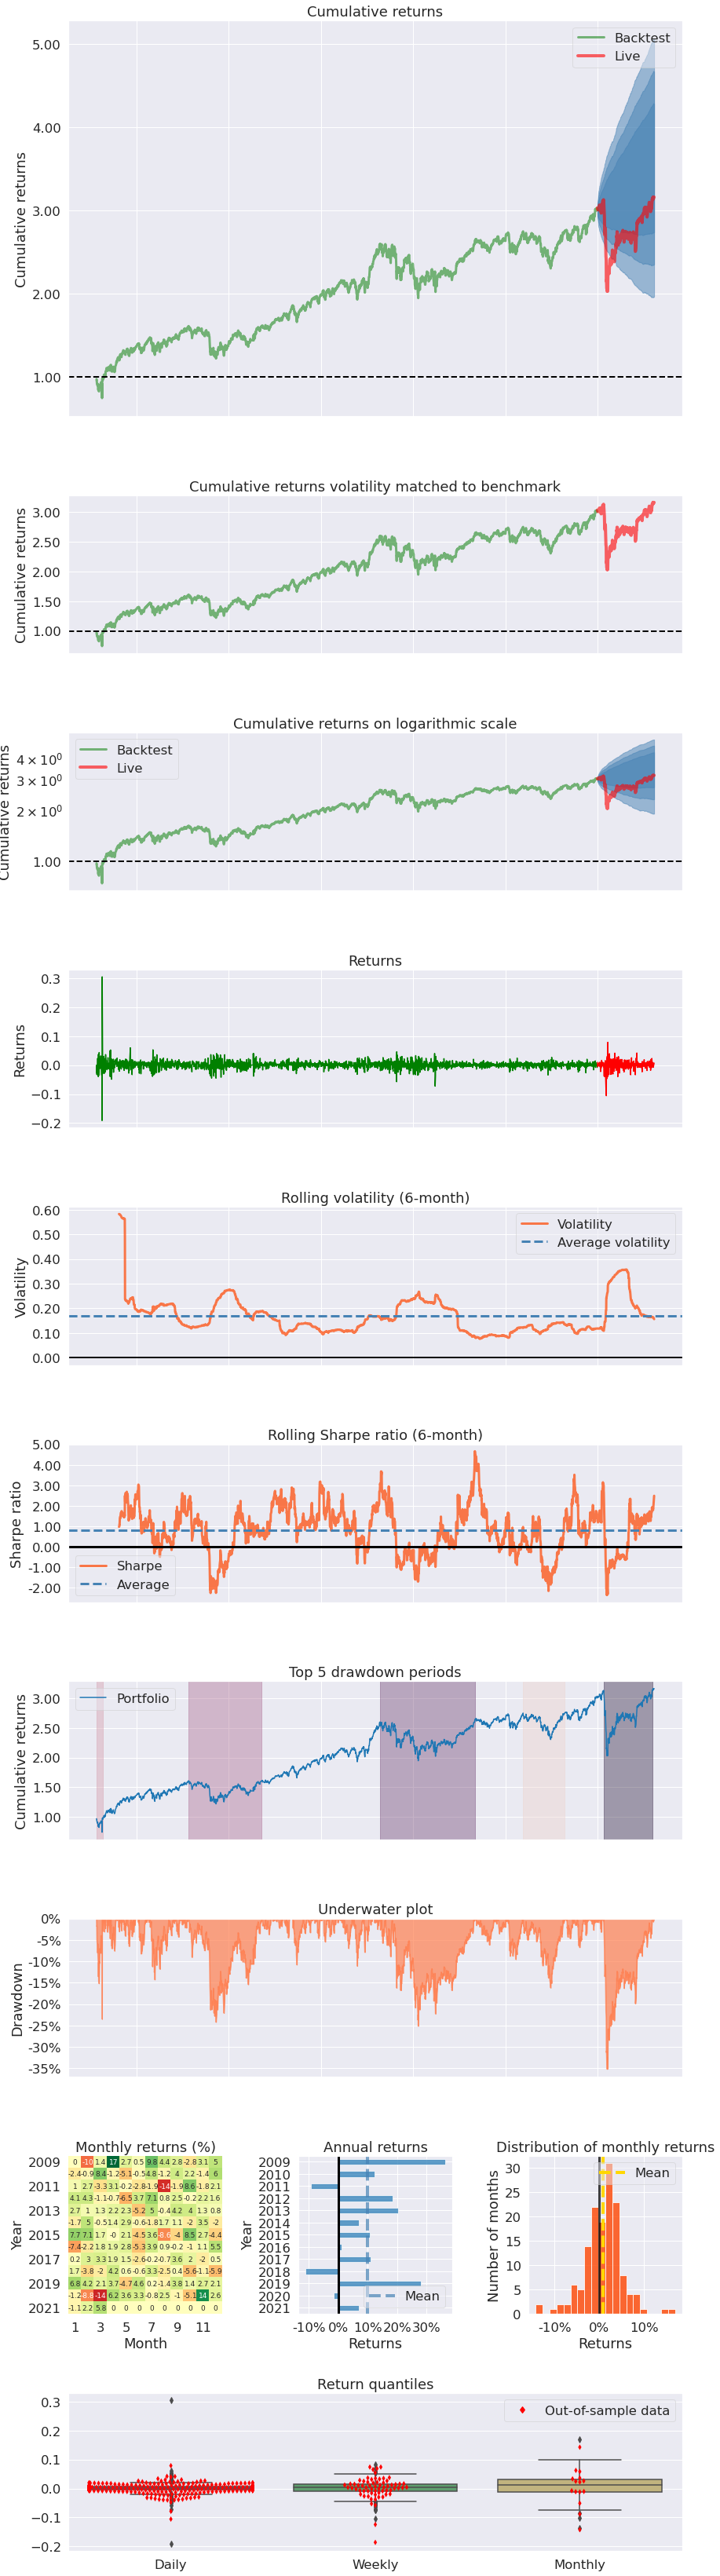

In [35]:
pf.create_returns_tear_sheet(returns = df_finax['XSX6.MI'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## XHYA

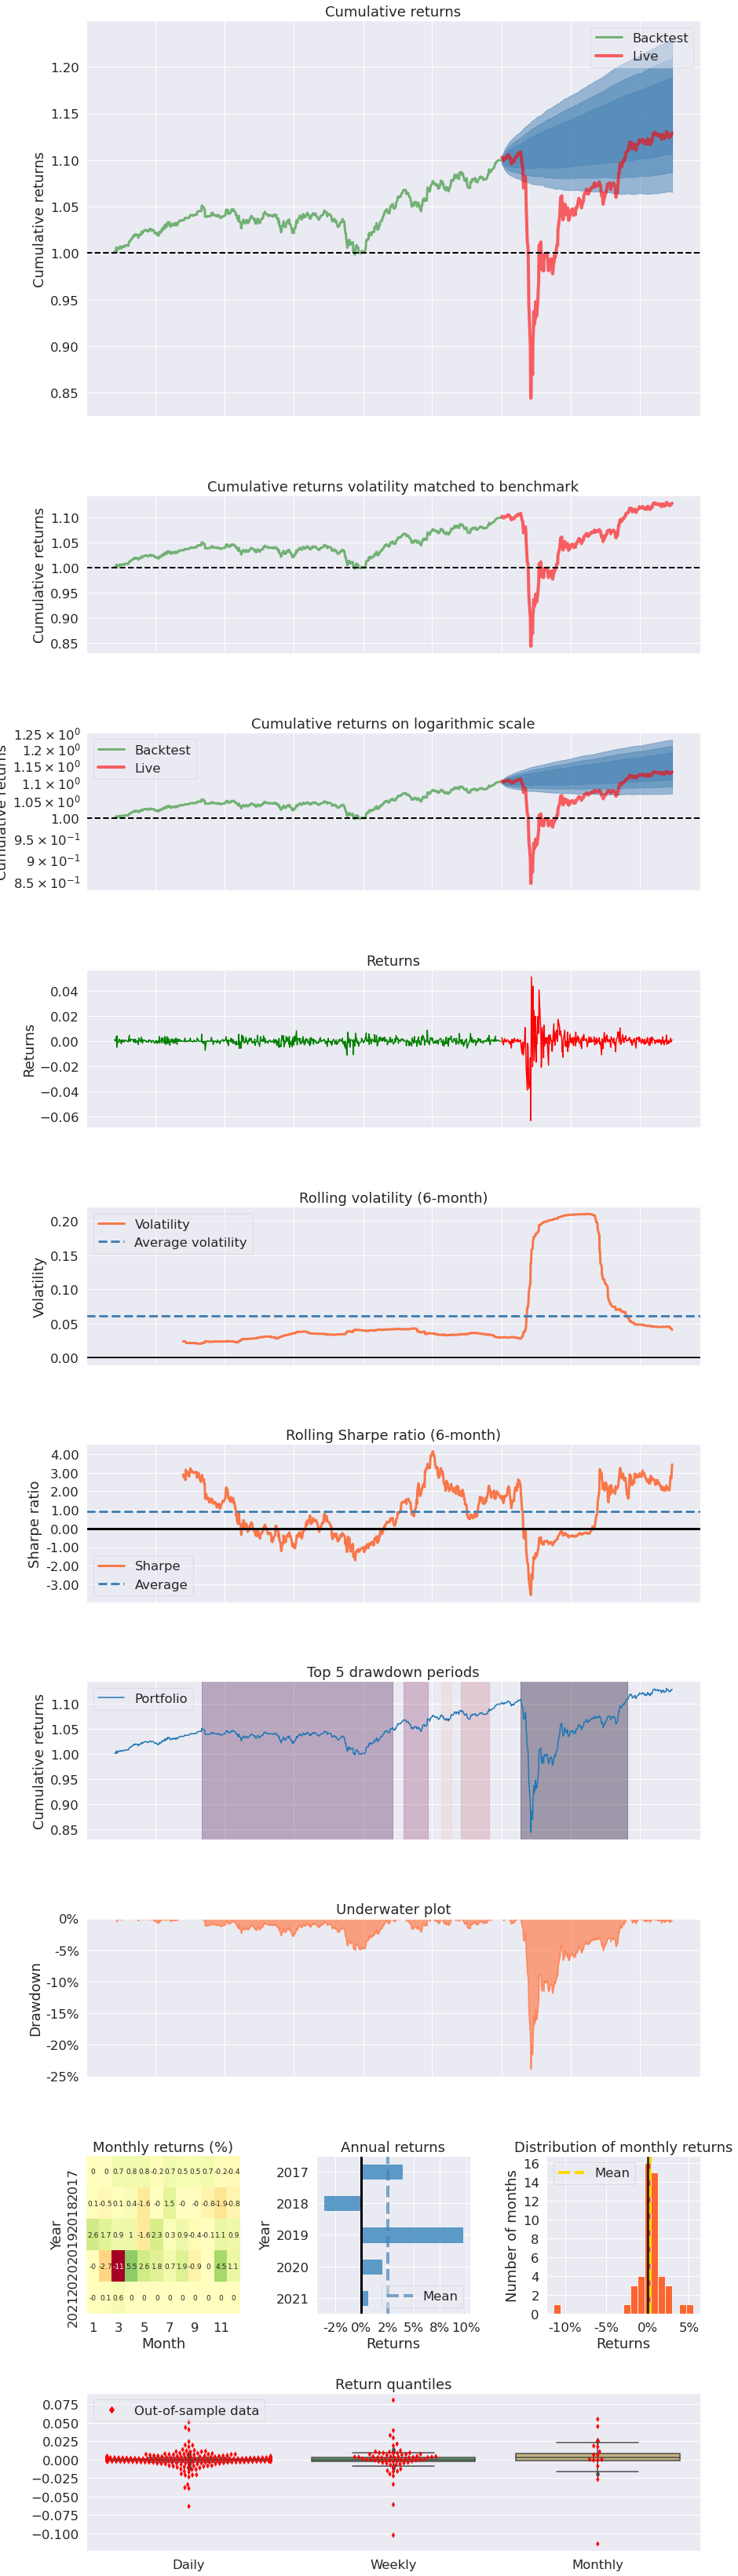

In [36]:
pf.create_returns_tear_sheet(returns = df_finax['XHYA.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## XBLC

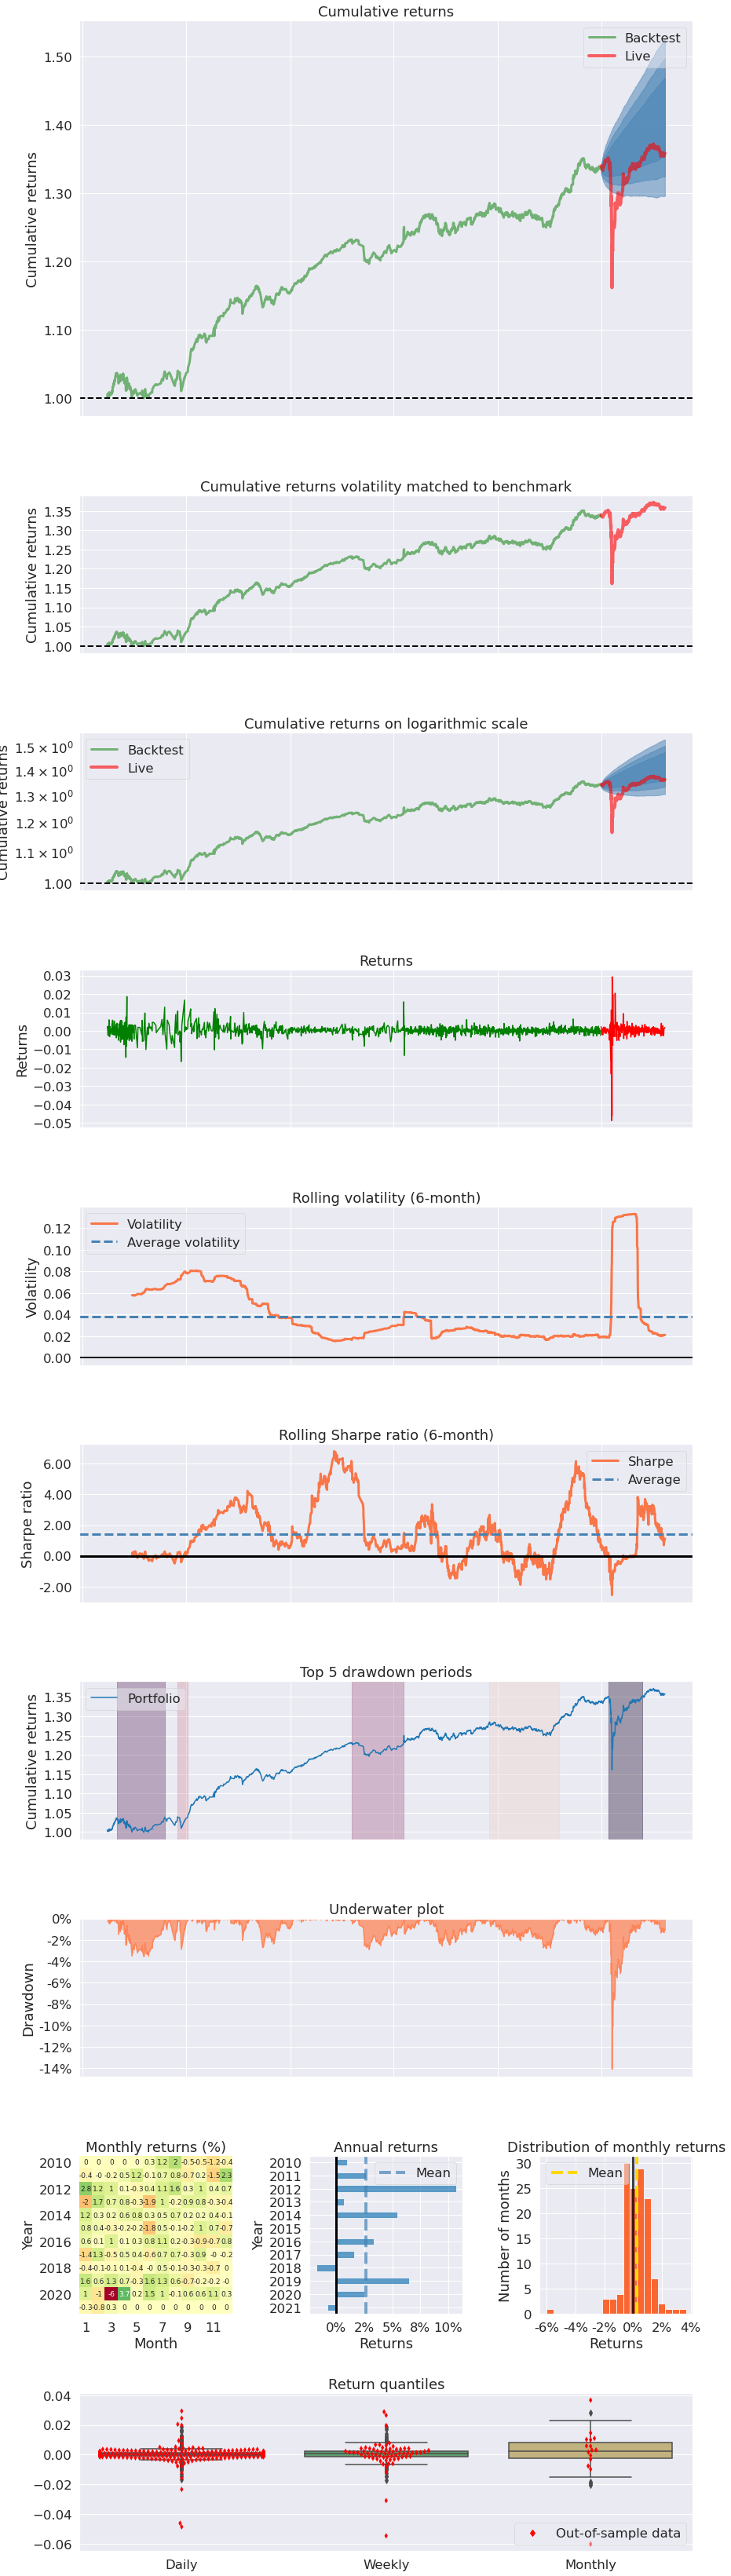

In [37]:
pf.create_returns_tear_sheet(returns = df_finax['XBLC.MI'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## IS3N

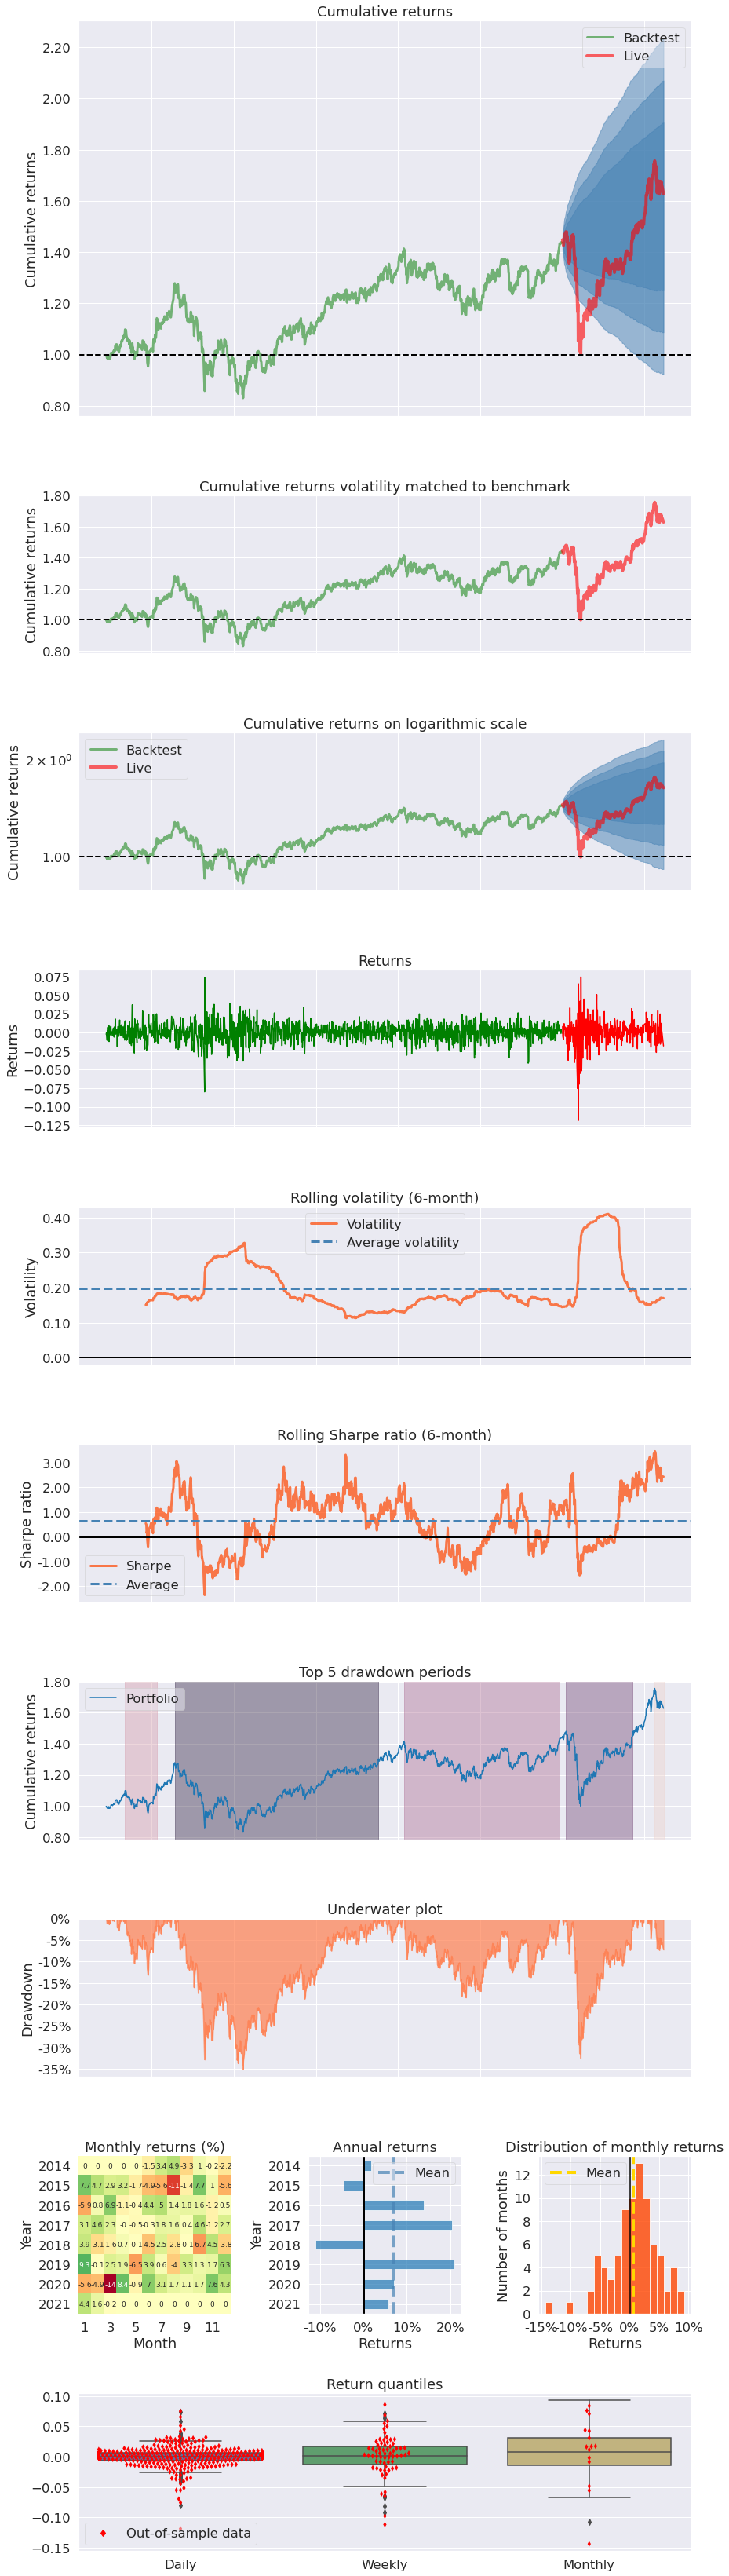

In [38]:
pf.create_returns_tear_sheet(returns = df_finax['IS3N.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## ZPRR

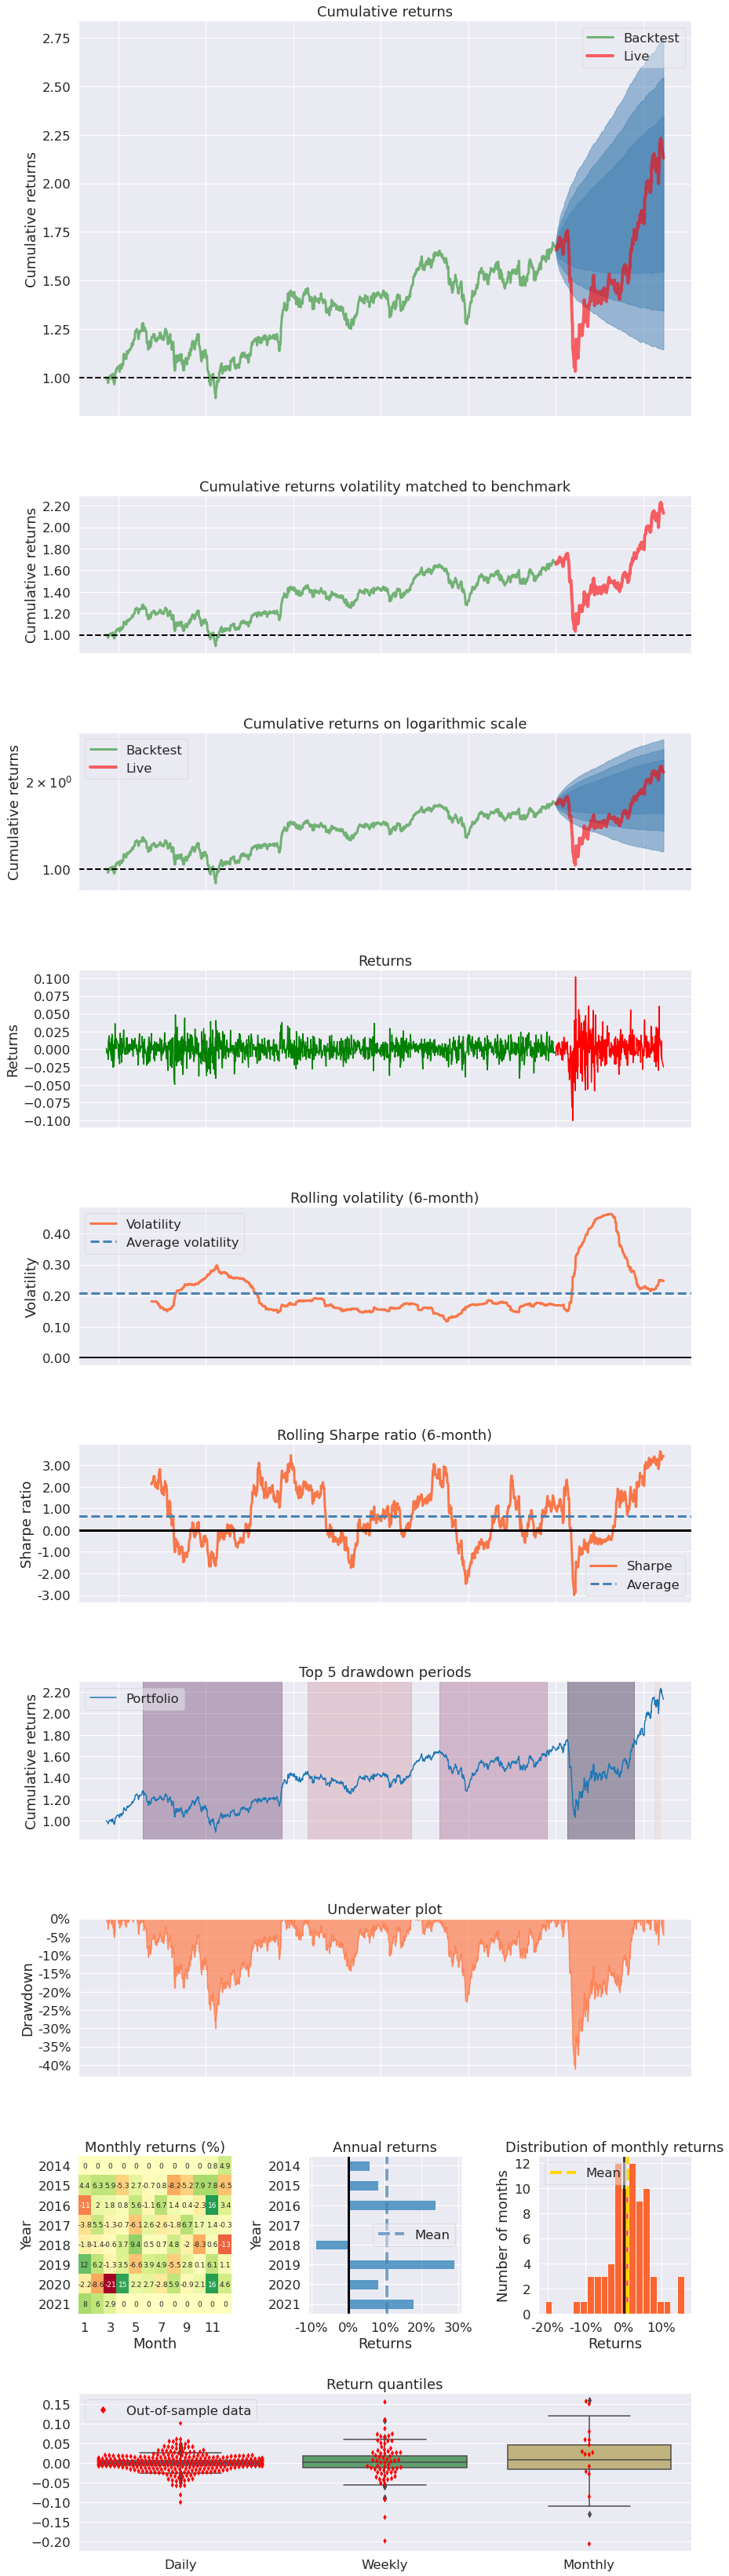

In [39]:
pf.create_returns_tear_sheet(returns = df_finax['ZPRR.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## SPY4

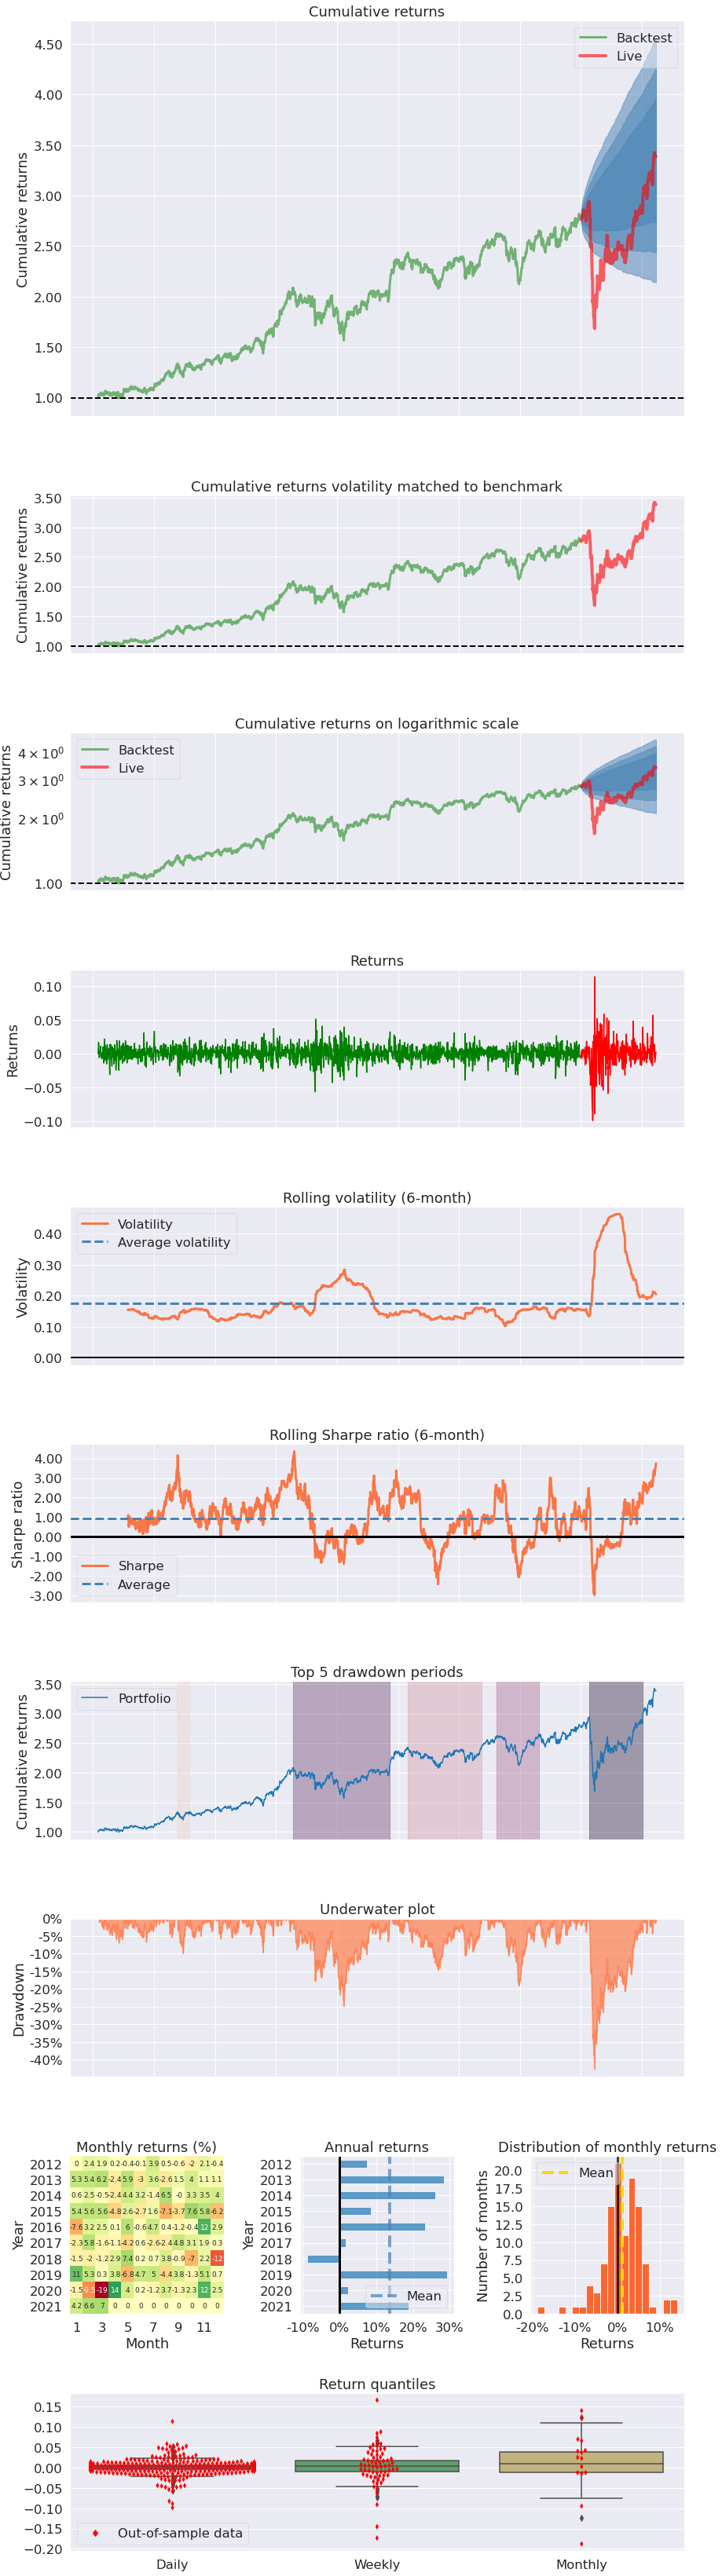

In [40]:
pf.create_returns_tear_sheet(returns = df_finax['SPY4.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

## SXR8

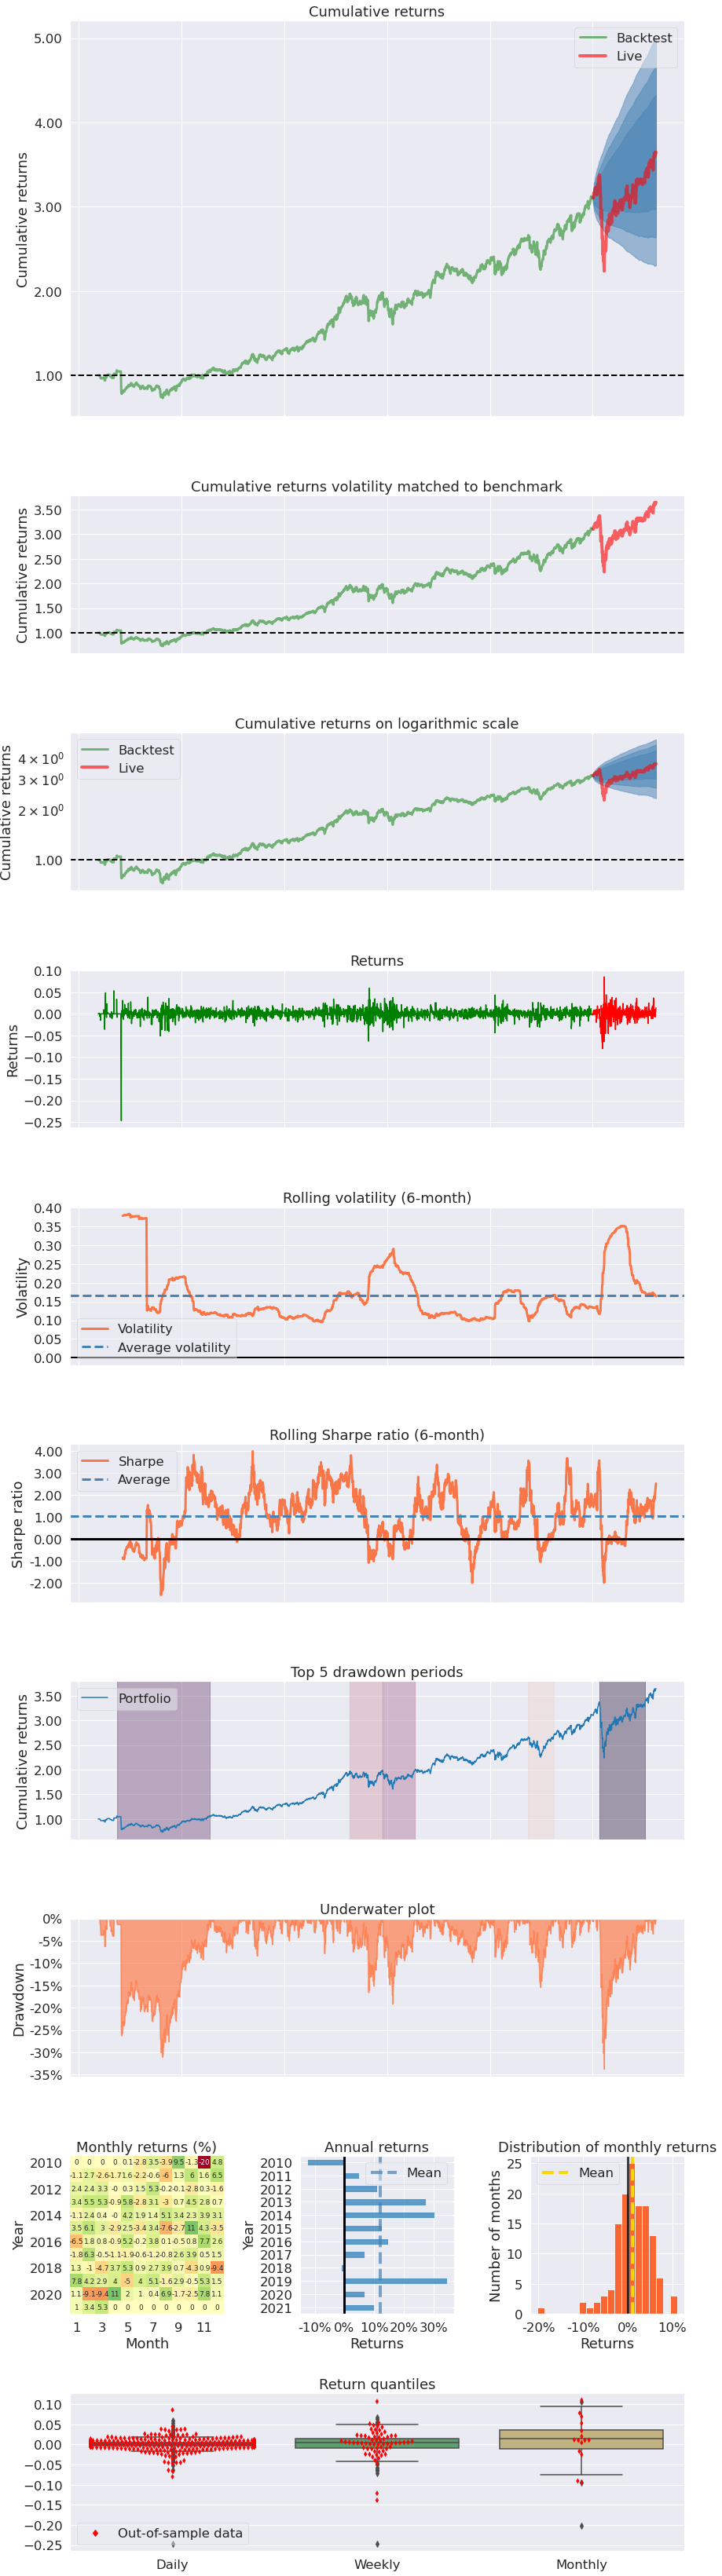

In [41]:
pf.create_returns_tear_sheet(returns = df_finax['SXR8.DE'].dropna().pct_change().dropna(), 
                             live_start_date = '2020-01-01')

# pyfolio stats in one df

In [42]:
s = df_finax.apply(lambda x: pf.timeseries.perf_stats(returns = x.dropna().pct_change().dropna())).T
pickle.dump(s, open('data/df_finax_stats.pickle', 'wb'))
s.style.background_gradient(cmap=cm, axis = 'rows')

# pyfolio stats viz

## parallel coordinates plot

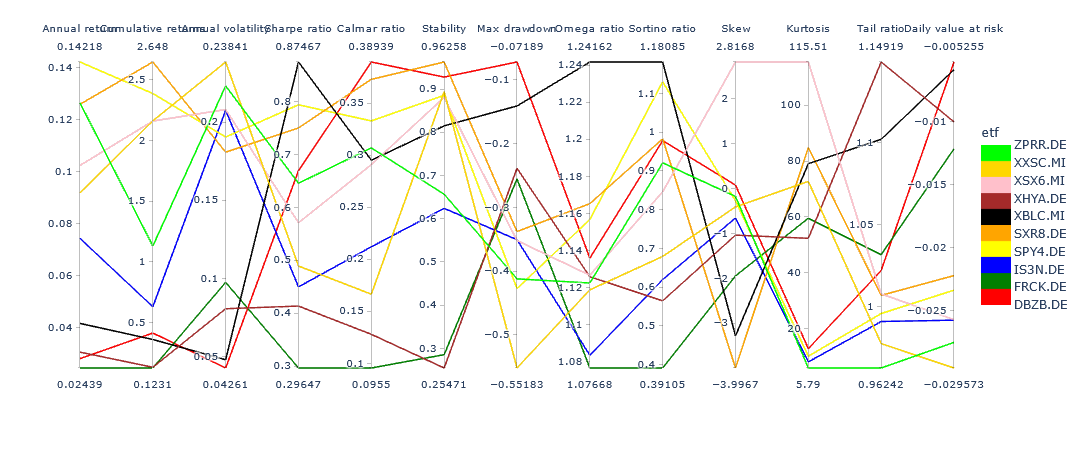

In [43]:
s['etf'] = [i for i in range(1, len(s) + 1)]
fig = px.parallel_coordinates(s, color = 'etf', 
                              dimensions = ['Annual return', 'Cumulative returns', 'Annual volatility',
                                            'Sharpe ratio', 'Calmar ratio', 'Stability', 'Max drawdown',
                                            'Omega ratio', 'Sortino ratio', 'Skew', 'Kurtosis', 'Tail ratio', 
                                           'Daily value at risk'],
                              color_continuous_scale=[(0., "red"),  (0.1, 'red'), 
                                                      (0.1, "green"), (0.2, 'green'),
                                                     (0.2, "blue"),  (0.3, 'blue'),
                                                      (0.3, "yellow"), (0.4, 'yellow'),
                                                     (0.4, "orange"), (0.5, 'orange'),  
                                                      (0.5, "black"), (0.6, 'black'),
                                                     (0.6, 'brown'), (0.7, 'brown'),
                                                      (0.7, 'pink'), (0.8, 'pink'),
                                                     (0.8, 'gold'), (0.9, 'gold'),
                                                      (0.9, 'lime'), (1, 'lime')])

fig.update_layout(coloraxis_colorbar=dict(
    title="etf",
    tickvals=[i for i in range(1, len(s) + 1)],
    ticktext=list(s.index),
    lenmode="pixels", len=200,
))

fig.show()

## sns pairplot

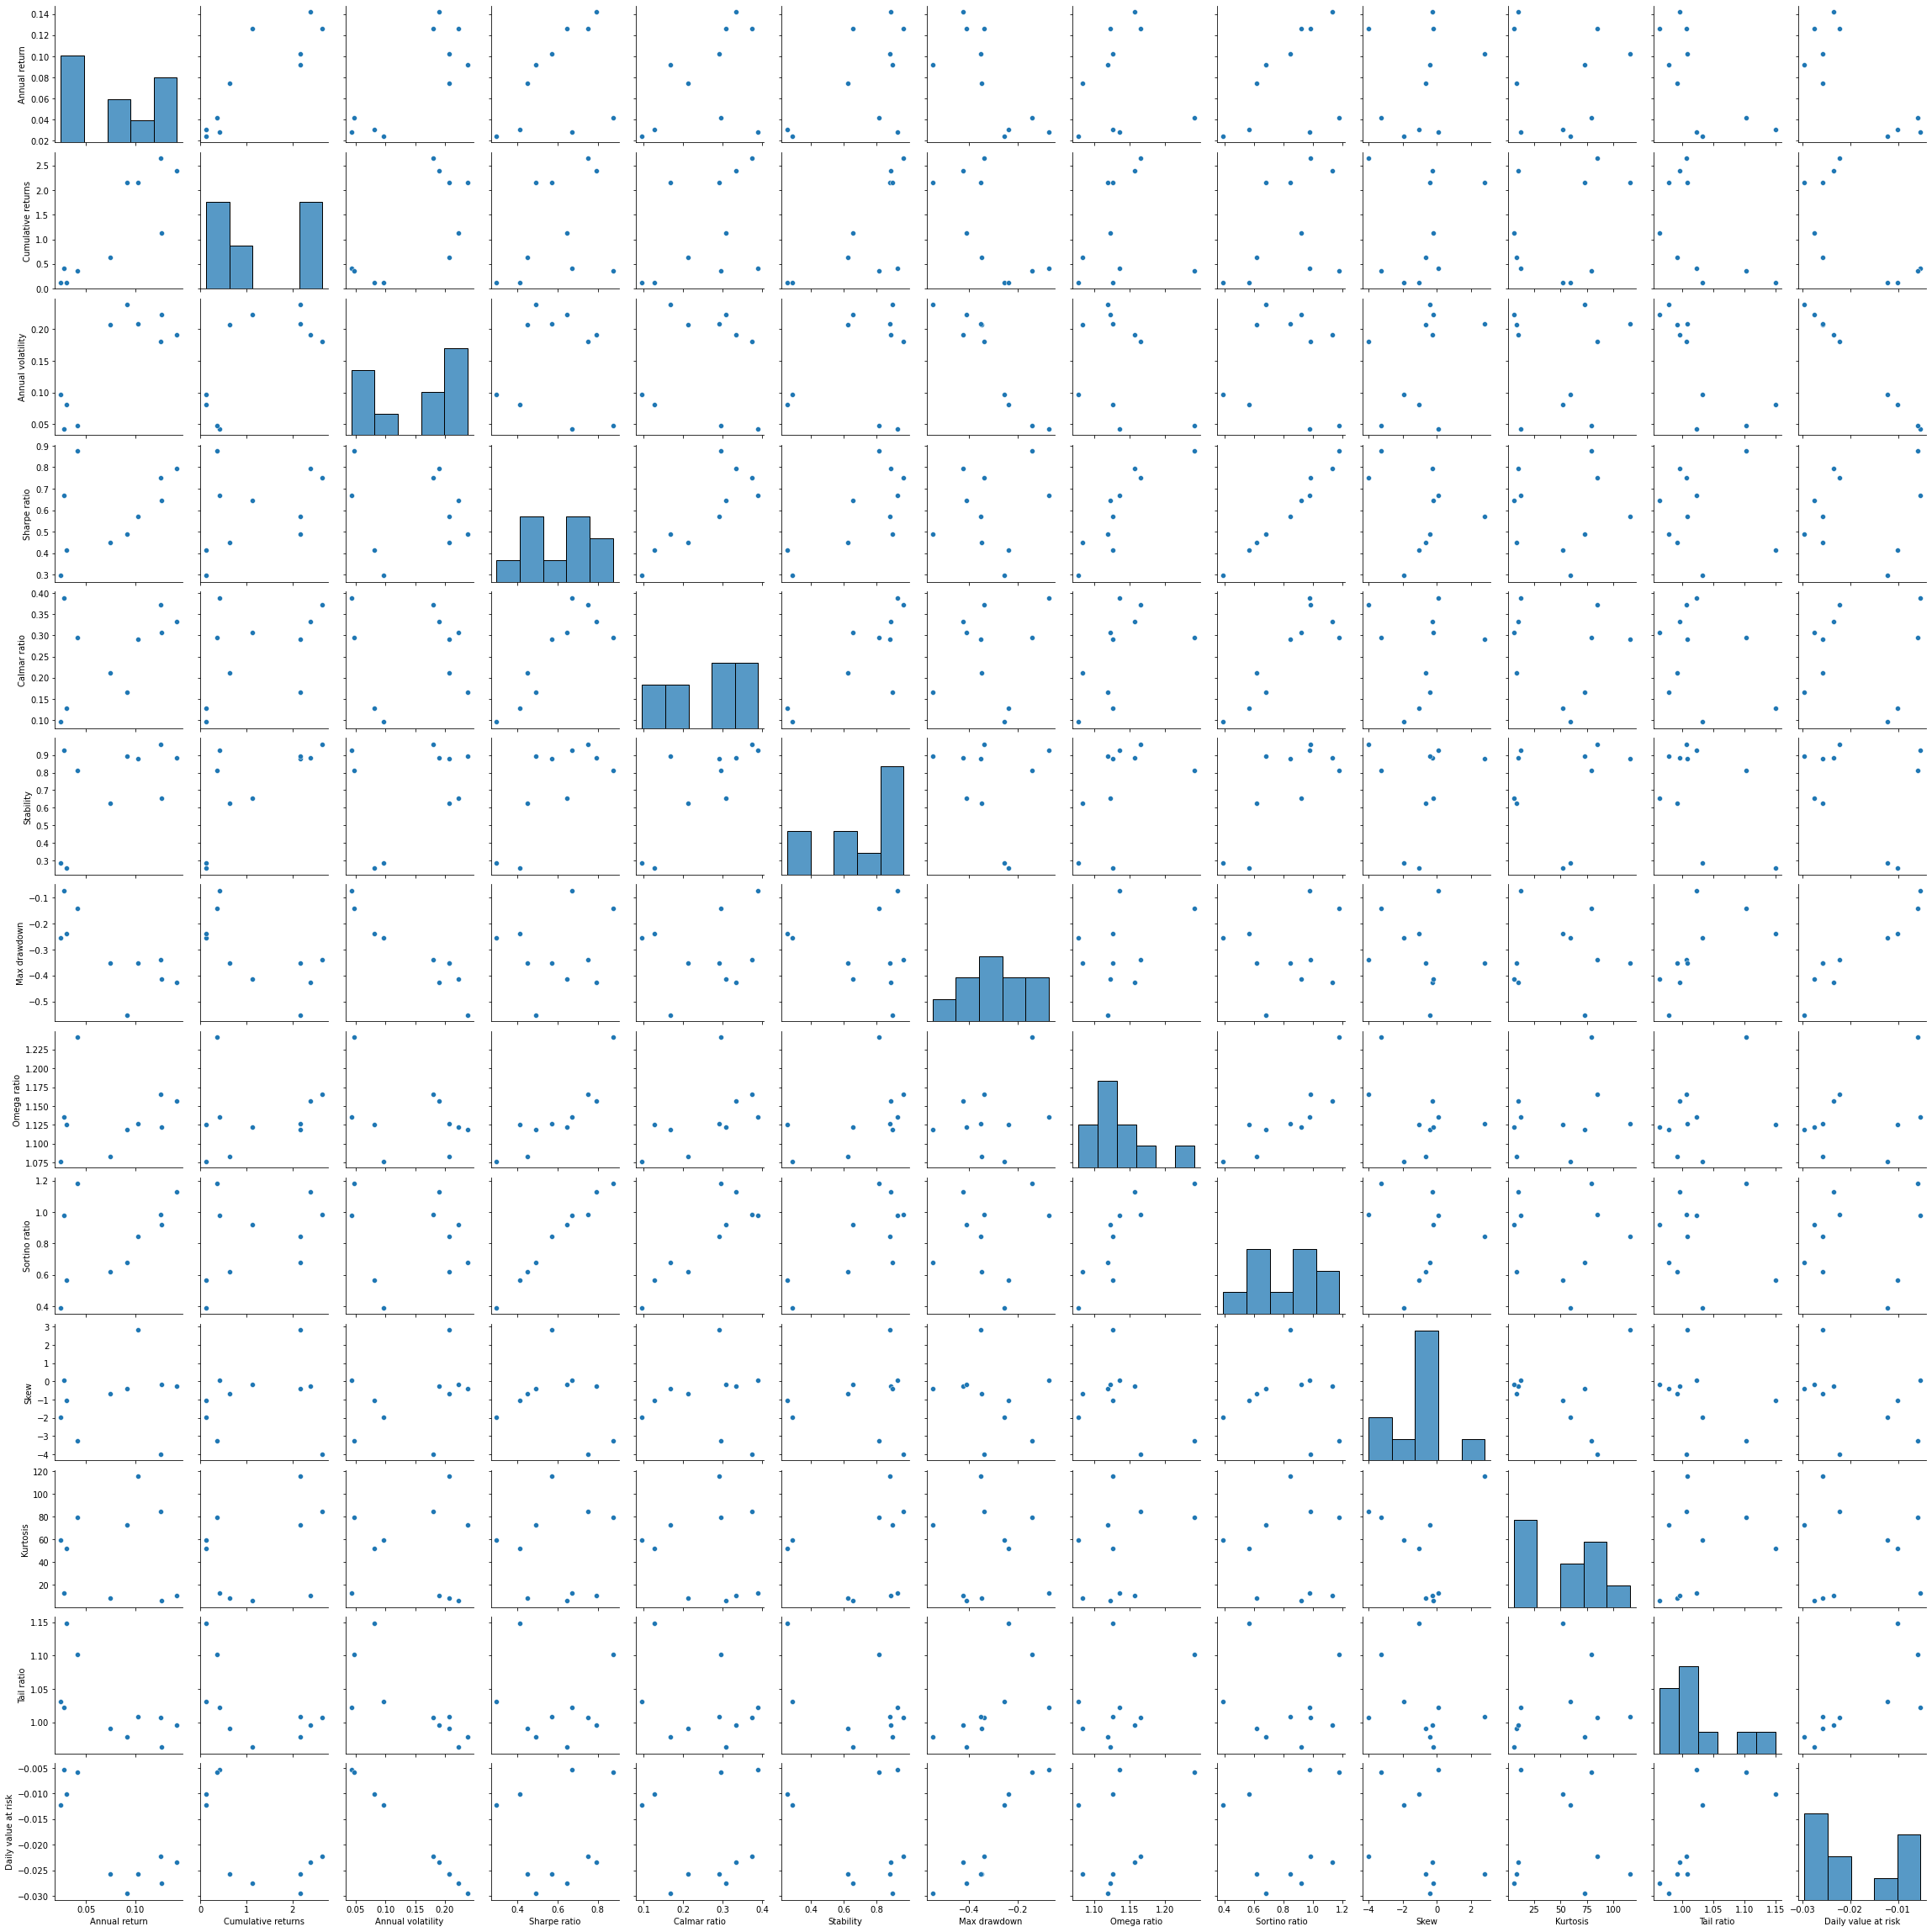

In [44]:
sns.pairplot(s.loc[:, s.columns[s.columns != 'etf']])

## pca

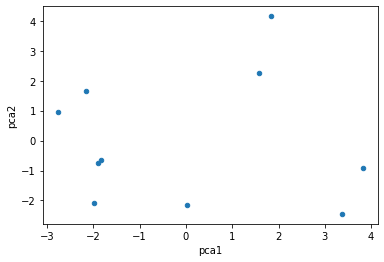

In [45]:
s_transformed = StandardScaler().fit_transform(s.loc[:, s.columns[s.columns != 'etf']])
pca = PCA(n_components = 2).fit(s_transformed)

t = pd.DataFrame(pca.transform(s_transformed), columns= ['pca1', 'pca2'])
t.plot.scatter(x = 'pca1', y = 'pca2')

In [46]:
pca.explained_variance_ratio_

array([0.42187554, 0.32893391])

# etf metadata test - eod

In [47]:
def get_eod_data(symbol='AAPL.US', api_token='xxxx', session=None):

    if session is None:
        session = requests.Session()
        url = 'https://eodhistoricaldata.com/api/eod/%s' % symbol
        url_fund = f'https://eodhistoricaldata.com/api/fundamentals/{symbol}?api_token={api_token}'
        url_etf = f'https://eodhistoricaldata.com/api/fundamentals/{symbol}?api_token={api_token}'
        params = {'api_token': api_token}
        r = session.get(url_etf, params=params)
        if r.status_code == requests.codes.ok:
            #df_url = pd.read_csv(StringIO(r.text), skipfooter=1, parse_dates=[0], index_col=0, engine='python')
            js = r

    return r

In [48]:
df = get_eod_data('AAPL.US', 'OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX')

In [49]:
# df.json() # too long
list(df.json().keys())

['General',
 'Highlights',
 'Valuation',
 'SharesStats',
 'Technicals',
 'SplitsDividends',
 'AnalystRatings',
 'Holders',
 'InsiderTransactions',
 'ESGScores',
 'outstandingShares',
 'Earnings',
 'Financials']

In [50]:
df = get_eod_data('VTI.US', 'OeAFFmMliFG5orCUuwAKQ8l4WWFQ67YX') # etf

In [51]:
import pprint
#pprint.pprint(df.json()[]) # too long
df.json().keys()

dict_keys(['General', 'Technicals', 'ETF_Data'])

In [52]:
list(df.json()['General'].keys())

['Code',
 'Type',
 'Name',
 'Exchange',
 'CurrencyCode',
 'CurrencyName',
 'CurrencySymbol',
 'CountryName',
 'CountryISO',
 'Description',
 'Category',
 'UpdatedAt']

In [53]:
list(df.json()['Technicals'].keys())

['Beta', '52WeekHigh', '52WeekLow', '50DayMA', '200DayMA']

In [54]:
list(df.json()['ETF_Data'].keys())

['ISIN',
 'Company_Name',
 'Company_URL',
 'ETF_URL',
 'Yield',
 'Dividend_Paying_Frequency',
 'Inception_Date',
 'Max_Annual_Mgmt_Charge',
 'Ongoing_Charge',
 'Date_Ongoing_Charge',
 'NetExpenseRatio',
 'AnnualHoldingsTurnover',
 'TotalAssets',
 'Average_Mkt_Cap_Mil',
 'Market_Capitalisation',
 'Asset_Allocation',
 'World_Regions',
 'Sector_Weights',
 'Fixed_Income',
 'Holdings_Count',
 'Top_10_Holdings',
 'Holdings',
 'Valuations_Growth',
 'MorningStar',
 'Performance']